In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as mdt
import MDAnalysis as mda
import aimmd
import aimmd.distributed as aimmdd

/home/tb/hejung/.conda/envs/aimmd_distributed_devel/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.
Tensorflow/Keras not available


In [3]:
# setup working directory

#scratch_dir = "."
#scratch_dir = "/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/"
scratch_dir = "/homeloc/scratch/aimmd_distributed/"

workdir = os.path.join(scratch_dir, "PathSampling_mda_test")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [5]:
# have a look at the default logging level (the level used for the root logger)
print(LOGCONFIG["loggers"][""])
# have a look at the logger for aimmd
print(LOGCONFIG["loggers"]["aimmd"])
# and have a look at the log-level for the filehandler
print(LOGCONFIG["handlers"]["stdf"])
# the last two should both be `INFO`

{'level': 'WARN', 'handlers': ['stdf', 'warnout']}
{'level': 'INFO'}
{'class': 'logging.FileHandler', 'level': 'INFO', 'mode': 'w', 'filename': 'simulation.log', 'formatter': 'standardFormatter'}


In [6]:
# OPTIONAL: more logging
#LOGCONFIG["handlers"]["stdf"]["level"] = "DEBUG"
#LOGCONFIG["loggers"]["aimmd"]["level"] = "DEBUG"

# TODO: this overwrites the logfiles from the simulation that we are continuing here!

In [7]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "simulation_continue_pathsampling.log")
#LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_pathsampling.log")
logging.config.dictConfig(LOGCONFIG)

# now the actual "setup"

In [8]:
storage = aimmd.Storage(os.path.join(workdir, "storage.h5"), mode="a")

In [9]:
model = storage.rcmodels["model_to_continue_with"]

In [10]:
trainset = storage.load_trainset()

In [11]:
tasks = [aimmdd.pathsampling.TrainingTask(model=model, trainset=trainset),
         aimmdd.pathsampling.SaveTask(storage=storage, model=model, trainset=trainset),
         aimmdd.pathsampling.DensityCollectionTask(model=model,
                                                   first_collection=100,
                                                   recreate_interval=500,
                                                   interval=10
                                                   ),
         ]

In [12]:
brain = storage.load_brain(model=model, tasks=tasks)

In [13]:
#brain = storage.central_memory.load_brain(model=model, tasks=tasks)

In [14]:
brain.total_steps

500

In [15]:
await brain.run_for_n_steps(500)
#await brain.run_for_n_steps(2000)
#await brain.run_for_n_accepts(25)

In [16]:
brain.total_steps

1000

In [17]:
len(trainset)

1000

In [18]:
print(model.log_train_decision[-1])

[False, 4.6290079001038955e-07, 3, 8192]


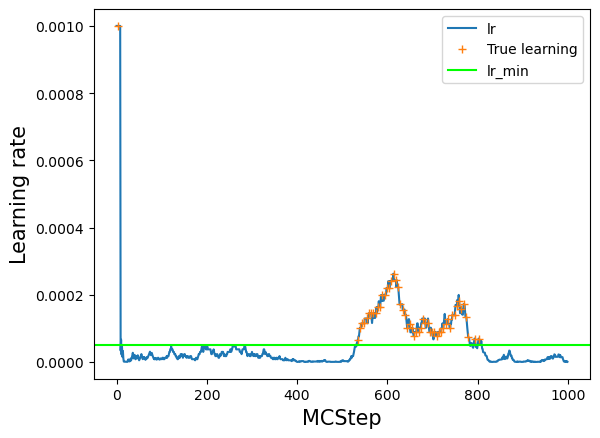

In [19]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

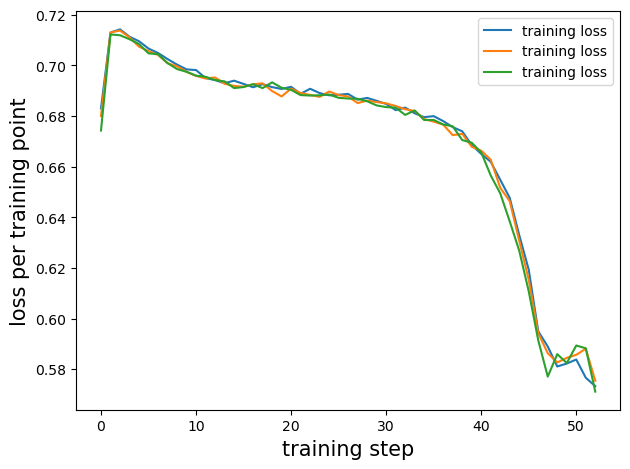

In [20]:
# the model losses at each step where it trained
# this will be epochs_per_training loss values per training
plt.plot(model.log_train_loss, label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('training step', size=15)
plt.tight_layout()

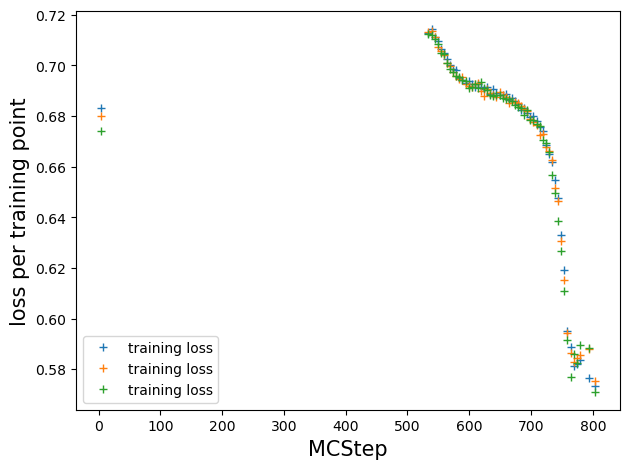

In [21]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

In [22]:
accepts = brain.accepts

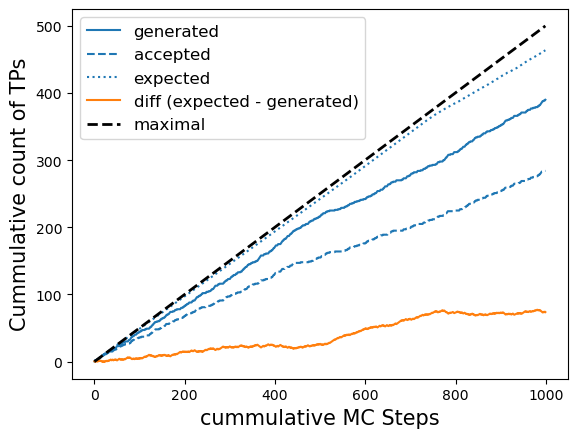

In [23]:
# plot efficiency, expected efficiency and accepts
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)

p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(brain.accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (expected - generated)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=12);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('cummulative MC Steps', size=15);

In [29]:
sum(len(s.mcstep_collection) for s in brain.samplers)

1004

In [30]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [31]:
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

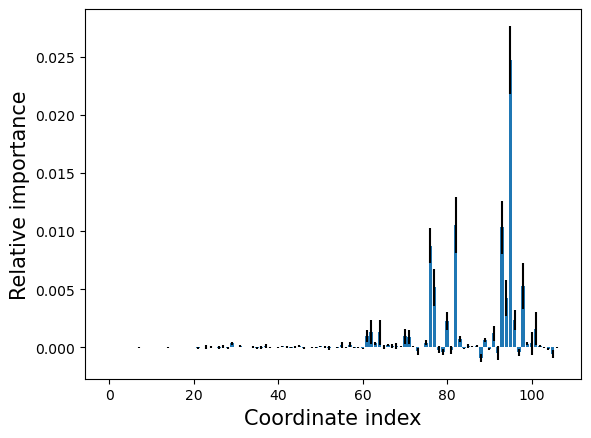

In [32]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [33]:
from state_funcs_mda import generate_atomgroups_for_ic

u = mda.Universe("gmx_infiles/ala_300K_amber99sb-ildn.tpr", "gmx_infiles/conf.gro",
                 refresh_offsets=True, tpr_resid_from_one=True)
molecule = u.select_atoms('protein')
pairs, triples, quadruples = generate_atomgroups_for_ic(molecule)

In [34]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]
sf_parms = {}

#pairs, triples, quadruples = aimmd.coords.internal.generate_indices(traj.topology, source_idx=1)

ic_parms = {"pairs": pairs, "triples": triples, "quadruples": quadruples}

print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:10]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx])
    if idx < len(pairs[0]):
        print(f"bond between: {pairs[0][idx]} and {pairs[1][idx]}")
        continue
    idx -= len(pairs[0])
    if idx < len(triples[0]):
        print(f"angle between {triples[0][idx]}, {triples[1][idx]} and {triples[2][idx]}")
        continue
    idx -= len(triples[0])
    if idx % 2 == 0:
        st = "sinus"
    else:
        st = "cosinus"
    st += f" of dihedral between {quadruples[0][idx // 2]}, {quadruples[1][idx // 2]}, {quadruples[2][idx // 2]} and {quadruples[3][idx // 2]}."
    print(st)
    #print(aimmd.coords.get_involved(idx, sf_parms=sf_parms, ic_parms=ic_parms, solvent_atoms=[['O', 'H']], solvent_resname=['HOH']))

reference loss: 0.5738045043945312

loss for idx 95:  0.5985230786132812
sinus of dihedral between <Atom 11: CB of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 9: CA of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 15: C of type C of resname ALA, resid 2 and segid seg_0_Protein_chain_A> and <Atom 17: N of type N of resname NME, resid 3 and segid seg_0_Protein_chain_A>.

loss for idx 82:  0.5843276586914062
cosinus of dihedral between <Atom 7: N of type N of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 9: CA of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 15: C of type C of resname ALA, resid 2 and segid seg_0_Protein_chain_A> and <Atom 17: N of type N of resname NME, resid 3 and segid seg_0_Protein_chain_A>.

loss for idx 93:  0.584147177734375
sinus of dihedral between <Atom 10: HA of type H1 of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 9: CA of type CT of resname ALA, re

In [36]:
# save the last model
storage.rcmodels["model_to_continue_with"] = model
storage.save_trainset(trainset)
storage.save_brain(brain)
# the rest should be saved automatically
# maybe we should save the model + trainset at the end of the simulation autmatically too?!

In [37]:
storage.close()